# 0. 필요 라이브러리 설치

In [ ]:
!pip install torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

     |████████████████████████████████| 5.6 MB 13.9 MB/s 
     |████████████████████████████████| 51 kB 8.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=34a64de88ade5babe3e569e3c42e217f3155a9c0e9aec4704a971d2c4b9f6a50
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


# 라이브러리 호출

In [ ]:
from IPython.display import clear_output
import numpy as np
import torch
from pypianoroll import Multitrack, BinaryTrack
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import matplotlib.pyplot as plt
import os
import pypianoroll
from pathlib import Path
import random

os.makedirs('result', exist_ok=True)

# 기본파라미터 세팅

In [ ]:
# Data
n_tracks = 1  # 사용되는 트랙의 수. 데이터 전처리 시 이 트랙 수는 모두 동일해야함.
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0]  # program number for each track
is_drums = [False]  # drum indicator for each track
track_names = ['Track 1']  # 각 트랙의 이름. 반드시 맞춰야 할 필요는 없음
tempo = 100

# Training
batch_size = 64
latent_dim = 1024
n_steps = 50000

# Sampling
sample_interval = 1000  # interval to run the sampler (in step)
n_samples = 4

measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)

# 학습에 사용하는 모델 및 함수 정의

In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_one_step(discriminator, generator, d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

class GeneraterBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneraterBlock(latent_dim, 512, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneraterBlock(512, 256, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneraterBlock(256, 128, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneraterBlock(128, 64, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneraterBlock(64, 32, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneraterBlock(32, 1, (1, 1, 12), (1, 1, 12))
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (3, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

# 데이터 전처리 함수(경우에 따라 생략 가능)

In [ ]:
def preprocess(path_str, filename):
  data = []
  path = Path(path_str).glob('**/*')
  # Load the multitrack as a pypianoroll.Multitrack instance
  for name in path:
      # multitrack = pypianoroll.load('lpd.npz')
      try:
          multitrack = pypianoroll.read(name)
      except:
          continue
      # Binarize the pianorolls
      multitrack.binarize()
      # Downsample the pianorolls (shape: n_timesteps x n_pitches)
      multitrack.set_resolution(beat_resolution)
      # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
      pianoroll = (multitrack.stack() > 0)
      # Get the target pitch range only
      pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
      # Calculate the total measures
      n_total_measures = multitrack.get_max_length() // measure_resolution
      candidate = n_total_measures - n_measures
      target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
      # Randomly select a number of phrases from the multitrack pianoroll
      for idx in np.random.choice(candidate, target_n_samples, False):
          start = idx * measure_resolution
          end = (idx + n_measures) * measure_resolution
          # Skip the samples where some track(s) has too few notes
          if (pianoroll.sum(axis=(1, 2)) < 10).any():
              continue
          data.append(pianoroll[:, start:end])
  # Stack all the collected pianoroll segments into one big array
  random.shuffle(data)
  data = np.stack(data)
  print(f"Data shape : {data.shape}")
  np.savez_compressed(f'{filename}.npz', data=data)

  preprocess('midis', 'midis') # 첫번째 인자는 midi파일이 있는 폴더명, 두번째 인자는 결과물로 출력될 npz파일의 이름

데이터 전처리 작업을 위해 데이터셋 전체를 코랩에 업로드하는 것은 번거로우므로
위 작업은 로컬PC에서 수행하고 결과물만 코랩에 업로드하는 것이 좋음

파일업로드는 아래 코드 사용

In [ ]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving Mozart.npz to Mozart.npz
User uploaded file "Mozart.npz" with length 91184 bytes


# 전처리된 데이터 로딩

In [ ]:
data = np.load('Mozart.npz')['data'] # 파일명은 상황에 맞게 적절히 수정하여 사용
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

# 모델 정의

In [ ]:
discriminator = Discriminator()
generator = Generator()

print("Number of parameters in G: {}".format(sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

Number of parameters in G: 2788643
Number of parameters in D: 186785


# 학습

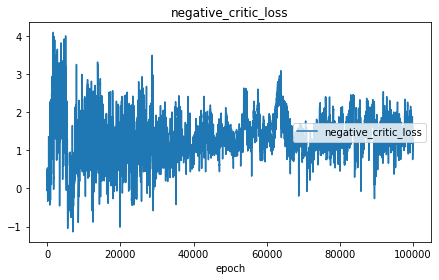

In [ ]:
step = 0
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(discriminator, generator, d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})
        # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        progress_bar.set_description_str("(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
                pianoroll = np.pad(samples[idx] > 0.5,((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
                tracks.append(BinaryTrack(name=track_name,program=program,is_drum=is_drum,pianoroll=pianoroll))
                
            m = Multitrack(tracks=tracks,tempo=tempo_array,resolution=beat_resolution)
            
            m.write(f'result/{str(step).zfill(5)}.mid')
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

# 테스트

(d_loss=-0.846008, g_loss=-20.297825): 100001it [1:28:42, 19.46it/s]            

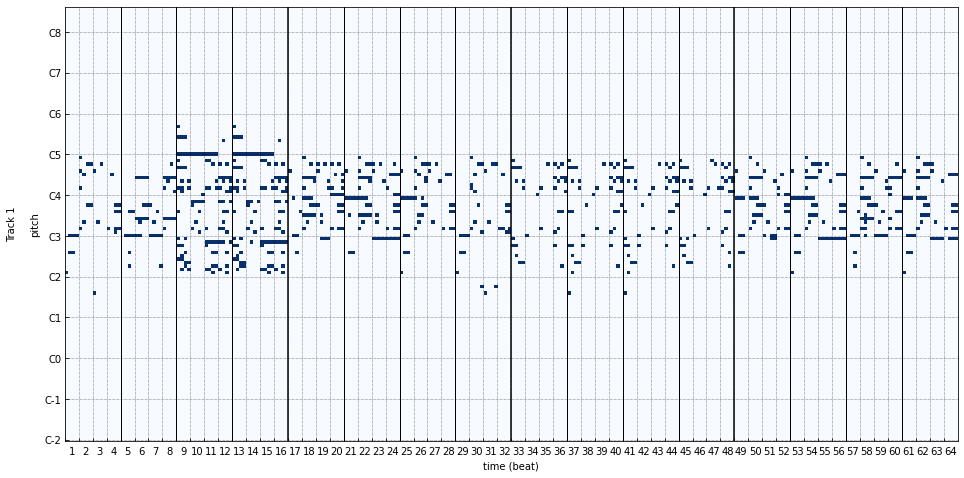

In [ ]:
generator.eval()

sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

samples = generator(sample_latent).cpu().detach().numpy()

# Display generated samples
samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
tracks = []
for idx, (program, is_drum, track_name) in enumerate(
    zip(programs, is_drums, track_names)
):
    pianoroll = np.pad(
        samples[idx] > 0.5,
        ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
    )
    tracks.append(
        BinaryTrack(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=pianoroll
        )
    )
m = Multitrack(
    tracks=tracks,
    tempo=tempo_array,
    resolution=beat_resolution
)
axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(
        measure_resolution,
        4 * measure_resolution * n_measures,
        measure_resolution
    ):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

m.write('result.mid')

In [ ]:
files.download('result.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 모델 저장
테스트 과정에서 생성된 generator 객체를 파일로 저장

In [ ]:
import pickle
with open('Mozart_epoch_100000.pkl', 'wb') as f:
    pickle.dump(generator, f)

In [ ]:
files.download('Beethoven_epoch_100000.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 모델 로드
이후 생성된 generator 객체를 테스트에 사용

In [ ]:
with open('generator.pkl', 'rb') as f:
    generator = pickle.load(f)